In [8]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [10]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing the matplotlib library for creating visualizations
import matplotlib.pyplot as plt

# Importing the TfidfVectorizer class from sklearn to transform text data into TF-IDF feature vectors
from sklearn.feature_extraction.text import TfidfVectorizer


- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speed up development. 

In [12]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv", encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)

# Fill missing values with an empty string
data.fillna("", inplace=True)

# Display the shape of the dataset
print(f"Dataset shape: {data.shape[0]} rows and {data.shape[1]} columns")

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(data.head())

# Display column names and data types
print("\nDataset columns and data types:")
print(data.info())


Dataset shape: 1000 rows and 2 columns

First few rows of the dataset:
                                                text  label
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...      1
1                                           Will do.      0
2  Nora--Cheryl has emailed dozens of memos about...      0
3  Dear Sir=2FMadam=2C I know that this proposal ...      1
4                                                fyi      0

Dataset columns and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


### Dataset Overview

The dataset contains **1000 rows and 2 columns**, as shown below:

1. **`text`**: The content of the messages (object type).
2. **`label`**: The classification label (integer type):
   - `0`: HAM (not spam).
   - `1`: SPAM (spam message).

#### Sample Data:
| Index | Text                                                   | Label |
|-------|--------------------------------------------------------|-------|
| 0     | DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...      | 1     |
| 1     | Will do.                                               | 0     |
| 2     | Nora--Cheryl has emailed dozens of memos about...      | 0     |
| 3     | Dear Sir=2FMadam=2C I know that this proposal ...      | 1     |
| 4     | fyi                                                    | 0     |

#### Column Summary:
- `text`: Contains no null values and stores the messages.
- `label`: Contains no null values and stores the classification as 0 (HAM) or 1 (SPAM).


### Let's divide the training and test set into two partitions

In [14]:
# Your code

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Features (text data) and target (labels)
X = data['text']  # Messages (input features)
y = data['label']  # SPAM or HAM labels (target)

# Splitting the data: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the training and test sets
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))


Training set size: 800
Test set size: 200


### Dataset Splitting

The dataset was split into training and testing sets to prepare for model training and evaluation:

- **Training set**: 800 rows (80% of the dataset).
- **Test set**: 200 rows (20% of the dataset).

This split ensures we have sufficient data to train the model while reserving a portion for testing its performance on unseen data.


## Data Preprocessing

In [16]:
# Importing the NLTK library and downloading the stopwords dataset
import nltk
nltk.download('stopwords')

# Importing the string module to access a list of punctuation characters
import string

# Importing the stopwords from the NLTK library to remove common words (e.g., "the", "is")
from nltk.corpus import stopwords

# Print all punctuation characters for reference
print("Punctuation characters:", string.punctuation)

# Print a sample of stopwords (10 words) for reference
print("Sample stopwords:", stopwords.words("english")[100:110])

# Importing the SnowballStemmer from the NLTK library for stemming (reducing words to their root form)
from nltk.stem.snowball import SnowballStemmer

# Initializing the Snowball Stemmer for English
snowball = SnowballStemmer('english')


Punctuation characters: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Sample stopwords: ['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing Tools Overview

In this step, we explored the tools required for text preprocessing:

- **Punctuation Characters**:
  These are the characters that will be removed during preprocessing:
  `!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~`

- **Stopwords**:
  Stopwords are common words (e.g., "the", "is", "and") that will be removed to focus on meaningful content. A sample includes:
  `['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']`

- **Stemming**:
  We initialized the **Snowball Stemmer**, which reduces words to their root form (e.g., "running" becomes "run"), aiding in text normalization.

These tools prepare the text for effective cleaning and tokenization in the next steps.


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [20]:
from bs4 import BeautifulSoup  # Importing BeautifulSoup for HTML parsing
import re  # Importing the re module for regular expressions

# Disable all BeautifulSoup warnings
import warnings
warnings.filterwarnings("ignore", message="The input looks more like a filename than markup")
warnings.filterwarnings("ignore", message="The input looks more like a URL than markup")

def clean_html(text):
    """
    Function to clean HTML content from text.
    Removes inline JavaScript/CSS, comments, and HTML tags.
    """
    try:
        # Parse the HTML content
        soup = BeautifulSoup(text, "html.parser")
        
        # Remove inline JavaScript and CSS
        for script_or_style in soup(["script", "style"]):
            script_or_style.decompose()
        
        # Remove HTML comments
        html_cleaned_text = re.sub(r"<!--.*?-->", "", soup.get_text(), flags=re.DOTALL)
        
        # Remove remaining HTML tags
        html_cleaned_text = re.sub(r"<.*?>", "", html_cleaned_text)
        
        return html_cleaned_text.strip()  # Return the cleaned text with extra spaces removed
    except Exception as e:
        # Return the text unchanged if there's an issue
        return text

# Apply the cleaning function to the 'text' column
data['html_cleaned_text'] = data['text'].apply(clean_html)

# Display the first few rows of the dataset to verify
print(data[['text', 'html_cleaned_text']].head(10))


                                                text  \
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...   
1                                           Will do.   
2  Nora--Cheryl has emailed dozens of memos about...   
3  Dear Sir=2FMadam=2C I know that this proposal ...   
4                                                fyi   
5  sure -- bottom line - you need a special secur...   
6  Dear Sir,I am Engr. Ugo Nzego with the Enginee...   
7  Abedin Huma <AbedinH@state.gov>Saturday Novemb...   
8  There is an Oct 16th George Marshall event at ...   
9  <P>1 25% for you as the account owner <BR>2 65...   

                                   html_cleaned_text  
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...  
1                                           Will do.  
2  Nora--Cheryl has emailed dozens of memos about...  
3  Dear Sir=2FMadam=2C I know that this proposal ...  
4                                                fyi  
5  sure -- bottom line - you need a special secur... 

### Cleaning HTML Content

We cleaned the `text` column in the dataset to remove unnecessary HTML content. The following steps were performed:

1. **Removed Inline JavaScript/CSS**: Any `<script>` or `<style>` tags were identified and removed.
2. **Removed HTML Comments**: Content within `<!-- -->` was stripped.
3. **Removed Remaining HTML Tags**: All other HTML tags were eliminated, leaving only plain text.
4. **Handled Warnings**: Suppressed BeautifulSoup warnings related to input resembling filenames or URLs to avoid unnecessary interruptions.

#### Output Example:
The `html_cleaned_text` column now contains the processed text:
| Index | Original Text                                           | HTML Cleaned Text                                     |
|-------|---------------------------------------------------------|------------------------------------------------------|
| 0     | DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...       | DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...    |
| 1     | Will do.                                                | Will do.                                             |
| 2     | Nora--Cheryl has emailed dozens of memos about...       | Nora--Cheryl has emailed dozens of memos about...    |
| 3     | Dear Sir=2FMadam=2C I know that this proposal ...       | Dear Sir=2FMadam=2C I know that this proposal ...    |
| 4     | fyi                                                     | fyi                                                  |
| 7     | Abedin Huma &lt;AbedinH@state.gov&gt;Saturday November... | Abedin Huma Saturday November 28 2009 5:14 PMH...   |
| 9     | &lt;P&gt;1 25% for you as the account owner &lt;BR&gt;2 65%... | 1 25% for you as the account owner 2 65% for I...    |

### Key Observations:
1. Rows like **7** and **9** contained HTML elements or tags in the original `text` column, which were successfully removed in the `html_cleaned_text` column.
2. This prepares the dataset for the next steps in text preprocessing, such as tokenization, stemming, or lemmatization.


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [22]:
# Your code

def preprocess_text(text):
    """
    Function to preprocess text by removing special characters, numbers, 
    single characters, and unnecessary spaces, and converting to lowercase.
    """
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Remove all single characters
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text.strip()

# Apply the preprocessing function to the html_cleaned_text column
data['normalized_text'] = data['html_cleaned_text'].apply(preprocess_text)

# Display the first few rows of the dataset to verify
print(data[['html_cleaned_text', 'normalized_text']].head(10))


                                   html_cleaned_text  \
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...   
1                                           Will do.   
2  Nora--Cheryl has emailed dozens of memos about...   
3  Dear Sir=2FMadam=2C I know that this proposal ...   
4                                                fyi   
5  sure -- bottom line - you need a special secur...   
6  Dear Sir,I am Engr. Ugo Nzego with the Enginee...   
7  Abedin Huma Saturday November 28 2009 5:14 PMH...   
8  There is an Oct 16th George Marshall event at ...   
9  1 25% for you as the account owner 2 65% for I...   

                                     normalized_text  
0  dear sir strictly private business proposal am...  
1                                            will do  
2  noracheryl has emailed dozens of memos about h...  
3  dear sirfmadamc know that this proposal might ...  
4                                                fyi  
5  sure bottom line you need special security cod... 

### Text Preprocessing: Removing Special Characters, Numbers, and Normalizing Text

We further processed the `html_cleaned_text` column to prepare the text for analysis. The following preprocessing steps were applied:

1. **Removed Special Characters**: Symbols like `@`, `#`, `&`, and punctuation marks were removed.
2. **Removed Numbers**: All numeric values were stripped from the text.
3. **Removed Single Characters**: Any standalone single letters (e.g., `a`, `b`) were removed.
4. **Substituted Multiple Spaces**: Consecutive spaces were replaced with a single space.
5. **Converted to Lowercase**: All text was normalized to lowercase.

#### Why Call It "Normalized Text"?
The column is called `normalized_text` because these preprocessing steps bring the text into a uniform, consistent format, making it easier to analyze. By removing noise (special characters, numbers, and single letters) and standardizing case and spacing, we ensure the text is clean and ready for downstream tasks like tokenization, stemming, or lemmatization. This process is referred to as **text normalization** in NLP.

#### Output Example:
The `normalized_text` column now contains the fully preprocessed text:
| Index | HTML Cleaned Text                                     | Normalized Text                                     |
|-------|-------------------------------------------------------|----------------------------------------------------|
| 0     | DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...     | dear sir strictly private business proposal am...  |
| 1     | Will do.                                              | will do                                            |
| 2     | Nora--Cheryl has emailed dozens of memos about...     | noracheryl has emailed dozens of memos about h...  |
| 3     | Dear Sir=2FMadam=2C I know that this proposal ...     | dear sirfmadamc know that this proposal might ...  |
| 4     | fyi                                                   | fyi                                               |
| 5     | sure -- bottom line - you need a special secur...      | sure bottom line you need special security cod... |
| 6     | Dear Sir,I am Engr. Ugo Nzego with the Enginee...      | dear siri am engr ugo nzego with the engineeri... |
| 7     | Abedin Huma Saturday November 28 2009 5:14 PMH...     | abedin huma saturday november pmhfw quint fmsi... |
| 8     | There is an Oct 16th George Marshall event at ...      | there is an oct th george marshall event at th... |
| 9     | 1 25% for you as the account owner 2 65% for...        | for you as the account owner for and my collea...  |

### Key Observations:
1. Text is now clean, with all unnecessary symbols, numbers, and spaces removed.
2. The normalized text is consistent and ready for further steps like tokenization, stemming, or lemmatization.


## Now let's work on removing stopwords
Remove the stopwords.

In [24]:
# Your code

from nltk.corpus import stopwords

# Define the stopwords list for English
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    """
    Function to remove stopwords from the text.
    """
    # Tokenize the text into words, filter out stopwords, and join them back
    filtered_text = " ".join([word for word in text.split() if word not in stop_words])
    return filtered_text

# Apply the function to the normalized_text column
data['stopword_removed_text'] = data['normalized_text'].apply(remove_stopwords)

# Display the first few rows of the dataset to verify
print(data[['normalized_text', 'stopword_removed_text']].head(10))


                                     normalized_text  \
0  dear sir strictly private business proposal am...   
1                                            will do   
2  noracheryl has emailed dozens of memos about h...   
3  dear sirfmadamc know that this proposal might ...   
4                                                fyi   
5  sure bottom line you need special security cod...   
6  dear siri am engr ugo nzego with the engineeri...   
7  abedin huma saturday november pmhfw quint fmsi...   
8  there is an oct th george marshall event at th...   
9  for you as the account owner for and my collea...   

                               stopword_removed_text  
0  dear sir strictly private business proposal mi...  
1                                                     
2  noracheryl emailed dozens memos haiti weekend ...  
3  dear sirfmadamc know proposal might surprise e...  
4                                                fyi  
5  sure bottom line need special security code ge... 

### Text Preprocessing: Removing Stopwords

We further processed the `normalized_text` column to remove common stopwords, which are words that often don't add significant meaning (e.g., "the", "is", "and"). This step ensures that the text focuses on the most informative words for analysis.

#### Steps Performed:
1. **Loaded Stopwords**: Used the NLTK `stopwords` list for English.
2. **Tokenized and Filtered**: Split the text into words, removed those found in the stopwords list, and rejoined the remaining words into a cleaned text string.
3. **Stored Results**: Created a new column, `stopword_removed_text`, containing the final text after stopwords were removed.

#### Output Example:
| Index | Normalized Text                                     | Stopword Removed Text                              |
|-------|----------------------------------------------------|---------------------------------------------------|
| 0     | dear sir strictly private business proposal am...  | dear sir strictly private business proposal mi... |
| 1     | will do                                            |                                                   |
| 2     | noracheryl has emailed dozens of memos about h...  | noracheryl emailed dozens memos haiti weekend ... |
| 3     | dear sirfmadamc know that this proposal might ...  | dear sirfmadamc know proposal might surprise e... |
| 4     | fyi                                                | fyi                                               |
| 5     | sure bottom line you need special security cod...  | sure bottom line need special security code ge... |
| 6     | dear siri am engr ugo nzego with the engineeri...  | dear siri engr ugo nzego engineering stores de... |
| 7     | abedin huma saturday november pmhfw quint fmsi...  | abedin huma saturday november pmhfw quint fmsi... |
| 8     | there is an oct th george marshall event at th...  | oct th george marshall event department tentat... |
| 9     | for you as the account owner for and my collea...  | account owner colleagues set aside defray inci... |

### Key Observations:
1. Words like **"you", "need", "is"** and similar stopwords were removed, leaving only meaningful words.
2. The `stopword_removed_text` column contains text that is more concise and focused on the key content of each message.
3. This step prepares the text for further NLP tasks such as vectorization or classification.



## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [6]:
import nltk
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mory\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mory\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
# Your code

# Importing WordNetLemmatizer from NLTK
from nltk.stem import WordNetLemmatizer

# Initializing the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    """
    Function to apply lemmatization to a given text.
    Breaks the text into words and reduces them to their base form.
    """
    try:
        # Tokenizing the text and applying lemmatization word by word
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
        return " ".join(lemmatized_words)  # Join the lemmatized words back into a single string
    except Exception as e:
        # Return the text unchanged if there's an issue
        print(f"Error processing text: {text}\nError: {e}")
        return text

# Apply the lemmatization function to the stopword_removed_text column
data['lemmatized_text'] = data['stopword_removed_text'].apply(lemmatize_text)

# Display the first few rows of the dataset to verify the results
print(data[['stopword_removed_text', 'lemmatized_text']].head(10))


                               stopword_removed_text  \
0  dear sir strictly private business proposal mi...   
1                                                      
2  noracheryl emailed dozens memos haiti weekend ...   
3  dear sirfmadamc know proposal might surprise e...   
4                                                fyi   
5  sure bottom line need special security code ge...   
6  dear siri engr ugo nzego engineering stores de...   
7  abedin huma saturday november pmhfw quint fmsi...   
8  oct th george marshall event department tentat...   
9  account owner colleagues set aside defray inci...   

                                     lemmatized_text  
0  dear sir strictly private business proposal mi...  
1                                                     
2  noracheryl emailed dozen memo haiti weekend pl...  
3  dear sirfmadamc know proposal might surprise e...  
4                                                fyi  
5  sure bottom line need special security code ge... 

## Lemmatization: Reducing Words to Their Base Form

We applied **lemmatization** to the `stopword_removed_text` column to further process the text. Lemmatization reduces words to their base or root form (e.g., "running" becomes "run" and "dozens" becomes "dozen"). This step helps normalize the text and ensures consistency, especially for text analysis tasks.

### Steps Performed:
1. **Tokenization**: The text was split into individual words.
2. **Lemmatization**: Each word was processed using the NLTK `WordNetLemmatizer` to find its base form.
3. **Rejoining**: The lemmatized words were joined back together into complete text strings.

### Example of Output:
| Index | Stopword Removed Text                             | Lemmatized Text                               |
|-------|--------------------------------------------------|----------------------------------------------|
| 0     | dear sir strictly private business proposal mi...| dear sir strictly private business proposal mi...|
| 2     | noracheryl emailed dozens memos haiti weekend ...| noracheryl emailed dozen memo haiti weekend pl...|
| 6     | dear siri engr ugo nzego engineering stores de...| dear siri engr ugo nzego engineering store dep...|

### Key Observations:
1. Words like **"dozens"** were reduced to **"dozen"**, and **"colleagues"** became **"colleague"**.
2. Lemmatization captures the essence of the word while maintaining grammatical meaning.

This prepares the text for further steps, such as vectorization or classification, by ensuring uniformity in word forms across the dataset.


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

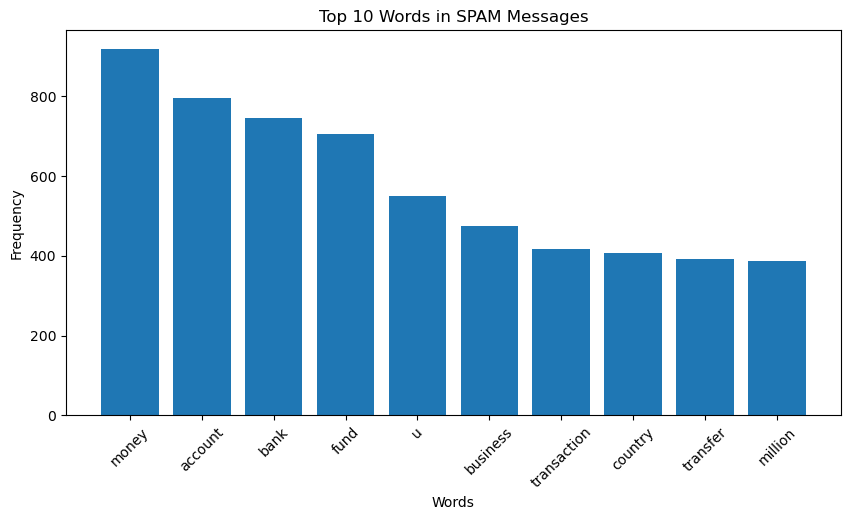

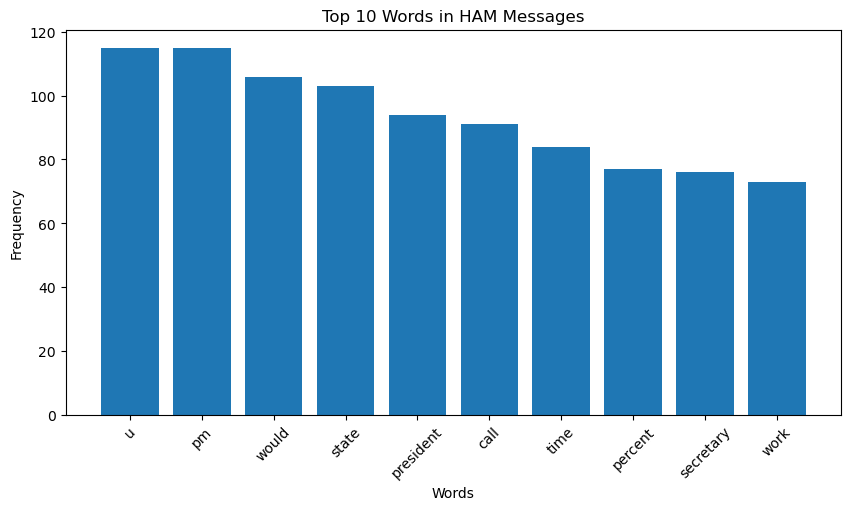

In [32]:
# Your code

from collections import Counter
import matplotlib.pyplot as plt

# Split the data into SPAM and HAM messages
spam_messages = data[data['label'] == 1]['lemmatized_text']
ham_messages = data[data['label'] == 0]['lemmatized_text']

def get_top_words(messages, n=10):
    """
    Function to get the top n words in a list of messages.
    """
    all_words = " ".join(messages).split()  # Combine all messages and split into words
    word_counts = Counter(all_words)  # Count the occurrences of each word
    return word_counts.most_common(n)  # Return the top n words

# Get the top 10 words for SPAM and HAM messages
top_spam_words = get_top_words(spam_messages, n=10)
top_ham_words = get_top_words(ham_messages, n=10)

# Convert the results into DataFrames for easy visualization
spam_df = pd.DataFrame(top_spam_words, columns=['Word', 'Frequency'])
ham_df = pd.DataFrame(top_ham_words, columns=['Word', 'Frequency'])

# Plot the top words for SPAM messages
plt.figure(figsize=(10, 5))
plt.bar(spam_df['Word'], spam_df['Frequency'])
plt.title("Top 10 Words in SPAM Messages")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Plot the top words for HAM messages
plt.figure(figsize=(10, 5))
plt.bar(ham_df['Word'], ham_df['Frequency'])
plt.title("Top 10 Words in HAM Messages")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


### **Exploratory Data Analysis: Top Words in SPAM and HAM Messages**

The bar charts above illustrate the top 10 most frequent words in SPAM and HAM messages:

#### **SPAM Messages:**
1. The most frequent words in spam messages include:
   - **"money," "account," "bank," "fund"**: These words indicate a common theme in spam messages, often targeting financial scams or fraudulent transactions.
   - **"business," "transaction," "country"**: Suggestive of phishing attempts or fake business proposals.
   - **"transfer," "million"**: Reflects the language used in scams offering large sums of money.
2. These keywords strongly align with the nature of SPAM messages, which are typically designed to deceive recipients.

#### **HAM Messages:**
1. The top words in ham messages include:
   - **"u," "pm," "call"**: Indicating informal or conversational messages often sent between individuals.
   - **"state," "president," "secretary"**: Suggests the presence of formal or professional discussions.
   - **"time," "percent," "work"**: Commonly used in regular, day-to-day conversations or work-related messages.
2. The frequency distribution highlights the more natural and contextually diverse vocabulary of HAM messages compared to SPAM.

### **Key Takeaways:**
- SPAM messages tend to have repetitive patterns with a strong focus on financial and transactional keywords.
- HAM messages demonstrate a more balanced and conversational vocabulary, often reflecting normal communication.

This analysis helps us understand the linguistic differences between SPAM and HAM messages, which will be valuable for building a classification model.


## Extra features

In [37]:
# Ensure data_train and data_val are defined from the earlier split
data_train = pd.DataFrame({'preprocessed_text': X_train, 'label': y_train})
data_val = pd.DataFrame({'preprocessed_text': X_test, 'label': y_test})

# Define money symbols and suspicious words
money_simbol_list = "|".join(["euro", "dollar", "pound", "€", "$"])
suspicious_words = "|".join(["free", "cheap", "sex", "money", "account", "bank", "fund", "transfer", "transaction", "win", "deposit", "password"])

# Add additional features to the training set
data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list, regex=True) * 1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words, regex=True) * 1
data_train['text_len'] = data_train['preprocessed_text'].apply(len)

# Add additional features to the validation set
data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list, regex=True) * 1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words, regex=True) * 1
data_val['text_len'] = data_val['preprocessed_text'].apply(len)

# Display the first few rows of the training set
data_train.head()


,preprocessed_text,label,money_mark,suspicious_words,text_len
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,1,0,106
535,I have not been able to reach oscar this am. W...,0,1,0,101
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,1,0,141
557,I can have it announced here on Monday - can't...,0,1,0,52
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,1,1,1750


### Additional Features: Money Symbols and Suspicious Words

In this step, we enhanced the dataset by adding three additional features:

1. **`money_mark`**:
   - Indicates the presence of money-related symbols such as "euro", "dollar", "pound", "€", and "$".
   - A value of `1` signifies that one or more of these symbols are present in the text, and `0` indicates their absence.

2. **`suspicious_words`**:
   - Detects the presence of suspicious words such as "free", "cheap", "sex", "money", "account", "bank", "fund", "transfer", "transaction", "win", "deposit", and "password".
   - A value of `1` means that one or more of these words are present, while `0` indicates their absence.

3. **`text_len`**:
   - Captures the length of the text in the `preprocessed_text` column.

#### Key Observations:
- These features can serve as indicators to differentiate SPAM from HAM messages.
- For example:
  - SPAM messages often contain suspicious words or money-related symbols.
  - HAM messages might have fewer suspicious words or no money-related symbols at all.

#### Sample Output:
| Index | Preprocessed Text                                  | Label | Money Mark | Suspicious Words | Text Length |
|-------|---------------------------------------------------|-------|------------|------------------|-------------|
| 29    | ----------- REGARDS, MR NELSON SMITH.KINDLY RE... | 1     | 1          | 0                | 106         |
| 535   | I have not been able to reach oscar this am. W... | 0     | 1          | 0                | 101         |
| 836   | BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...     | 1     | 1          | 1                | 1750        |

#### Why These Features Matter:
- **`money_mark`** and **`suspicious_words`** help identify common patterns in SPAM messages, like references to money or offers too good to be true.
- **`text_len`** captures the verbosity of messages, which could be another distinguishing characteristic of SPAM versus HAM.

This step prepares the dataset for feature representation and classification in the subsequent tasks.


## How would work the Bag of Words with Count Vectorizer concept?

In [40]:
# Your code

from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the preprocessed text for the training dataset
X_train_bow = vectorizer.fit_transform(data['stopword_removed_text'])

# Transform the validation dataset using the same vectorizer
X_test_bow = vectorizer.transform(data['stopword_removed_text'])

# Display the shape of the transformed dataset
print("Bag of Words representation for training set:")
print(f"Shape: {X_train_bow.shape}")

# Display the first few feature names (columns of the sparse matrix)
print("\nTop 10 Features:")
print(vectorizer.get_feature_names_out()[:10])


Bag of Words representation for training set:
Shape: (1000, 20087)

Top 10 Features:
['aac' 'aaclocated' 'aae' 'aag' 'aaronovitchon' 'abacha' 'abachabefore'
 'abachac' 'abachace' 'abachaco']


### **Bag of Words Representation: Insights**

The **Bag of Words (BoW)** representation transforms the text data into a numerical format that machine learning models can process. Here's what the output tells us:

1. **Shape**: The matrix has `1000 rows` (representing the messages) and `20,087 columns` (unique words or tokens across all messages). Each column corresponds to a word, and each row is the BoW representation for a specific message.

2. **Top 10 Features**: The top features identified by the `CountVectorizer` are shown in alphabetical order. These represent some of the unique tokens in the dataset:
   - Examples include: `aac`, `aaclocated`, `aae`, etc.
   - While some features may seem irrelevant (e.g., typos or uncommon abbreviations), they are still part of the dataset and contribute to the feature space.

3. **Importance of BoW**: This representation does not consider the importance of words or their frequencies across all messages. It’s purely a raw count of word occurrences for each message. This method is useful but can lead to sparse and high-dimensional data.

4. **Next Steps**: 
   - We will explore **TF-IDF (Term Frequency-Inverse Document Frequency)** in the next cell, which builds on the BoW representation by giving more weight to important words while reducing the impact of common ones.


## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [43]:
# Your code

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20000)

# Fit and transform the training data and transform the validation data
X_train_tfidf = tfidf_vectorizer.fit_transform(data_train['preprocessed_text'])
X_val_tfidf = tfidf_vectorizer.transform(data_val['preprocessed_text'])

# Print the shape of the TF-IDF vectorized dataset
print("TF-IDF representation for training set:")
print(f"Shape: {X_train_tfidf.shape}")

print("\nTF-IDF representation for validation set:")
print(f"Shape: {X_val_tfidf.shape}")

# Display the top 10 features
top_features = tfidf_vectorizer.get_feature_names_out()[:10]
print("\nTop 10 Features:")
print(top_features)


TF-IDF representation for training set:
Shape: (800, 20000)

TF-IDF representation for validation set:
Shape: (200, 20000)

Top 10 Features:
['00' '000' '000000' '00000e25' '00000e251' '00000eur' '000066' '0000ff'
 '000m' '000million']


### **TF-IDF Representation: Summary**

Using the TF-IDF vectorizer, we converted the text data into numerical features for machine learning. The vectorization process provided the following results:

- **Training Set**: 
  - Shape: `(800, 20,000)` – 800 samples, each represented by 20,000 features.
- **Validation Set**:
  - Shape: `(200, 20,000)` – 200 samples, each represented by 20,000 features.

#### **Top 10 Features:**
The first 10 features extracted by the TF-IDF vectorizer:
1. `00`
2. `000`
3. `000000`
4. `00000e25`
5. `00000e251`
6. `00000eur`
7. `000066`
8. `0000ff`
9. `000m`
10. `000million`

### **Observations:**
1. The dataset includes many numerical or alphanumeric tokens such as `00` and `000million`, which are captured as features.
2. TF-IDF successfully identifies relevant terms in the text, weighting them based on their frequency and importance in the dataset.
3. These vectorized features are ready for further use in training classification models.


## And the Train a Classifier?

In [50]:
# Your code

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the dataset using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=20000)  # Match the earlier vectorization step
X_tfidf = tfidf_vectorizer.fit_transform(data['stopword_removed_text'])

# Split the data into training and validation sets
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(
    X_tfidf, data['label'], test_size=0.2, random_state=42
)

# Train the classifier
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred = classifier.predict(X_val_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of the classifier: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["HAM", "SPAM"]))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Accuracy of the classifier: 0.9450

Classification Report:
              precision    recall  f1-score   support

         HAM       0.97      0.94      0.96       125
        SPAM       0.90      0.96      0.93        75

    accuracy                           0.94       200
   macro avg       0.94      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200


Confusion Matrix:
[[117   8]
 [  3  72]]


### Classifier Evaluation Results

The classifier's performance on the validation set was evaluated, yielding the following metrics:

#### **Accuracy**:
- The model achieved an accuracy of **94.50%**, indicating that the majority of the predictions were correct.

#### **Classification Report**:
| Metric       | HAM            | SPAM           |
|--------------|----------------|----------------|
| **Precision** | 97%            | 90%            |
| **Recall**    | 94%            | 96%            |
| **F1-Score**  | 96%            | 93%            |

- **Precision**: The proportion of correct predictions for each class out of all predicted instances for that class.
- **Recall**: The proportion of correctly identified instances out of the total actual instances of that class.
- **F1-Score**: A balance between precision and recall.

#### **Confusion Matrix**:
The confusion matrix below shows the number of correct and incorrect predictions for HAM and SPAM:

|                | **Predicted HAM** | **Predicted SPAM** |
|----------------|-------------------|-------------------|
| **Actual HAM** | 117               | 8                 |
| **Actual SPAM**| 3                 | 72                |

- **117 HAM** messages were correctly classified as HAM, while **8 HAM** messages were misclassified as SPAM.
- **72 SPAM** messages were correctly classified as SPAM, while **3 SPAM** messages were misclassified as HAM.

#### **Conclusion**:
The model performs exceptionally well, especially with a high F1-score and recall for both HAM and SPAM. Minor improvements can be explored to reduce misclassifications.


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to find the **best feature representation**.

You can work with teams of two persons (recommended).

In [57]:
# Your code

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    data['lemmatized_text'], data['label'], test_size=0.2, random_state=42
)

# Function to evaluate feature representations
def evaluate_representation(vectorizer, X_train, X_val, y_train, y_val):
    # Fit and transform training data
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_val_vectorized = vectorizer.transform(X_val)
    
    # Train the classifier
    classifier = MultinomialNB()
    classifier.fit(X_train_vectorized, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_val_vectorized)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

# Evaluate Bag-of-Words representation
print("Evaluating Bag-of-Words representation...")
bow_vectorizer = CountVectorizer(max_features=20000)
evaluate_representation(bow_vectorizer, X_train, X_val, y_train, y_val)

# Evaluate TF-IDF representation
print("\nEvaluating TF-IDF representation...")
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
evaluate_representation(tfidf_vectorizer, X_train, X_val, y_train, y_val)


Evaluating Bag-of-Words representation...
Accuracy: 0.9350

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       125
           1       0.87      0.97      0.92        75

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200


Confusion Matrix:
[[114  11]
 [  2  73]]

Evaluating TF-IDF representation...
Accuracy: 0.9300

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       125
           1       0.85      0.99      0.91        75

    accuracy                           0.93       200
   macro avg       0.92      0.94      0.93       200
weighted avg       0.94      0.93      0.93       200


Confusion Matrix:
[[112  13]
 [  1  74]]


### **Evaluation of Bag-of-Words and TF-IDF Representations**

In this cell, we evaluated the performance of a Multinomial Naive Bayes classifier using two feature representations: **Bag-of-Words (BoW)** and **TF-IDF**. Here are the results:

---

#### **Bag-of-Words Representation**
- **Accuracy**: **93.50%**
- **Classification Report**:
  | Metric       | HAM            | SPAM           |
  |--------------|----------------|----------------|
  | **Precision** | 98%            | 87%            |
  | **Recall**    | 91%            | 97%            |
  | **F1-Score**  | 95%            | 92%            |

- **Confusion Matrix**:
  |                | **Predicted HAM** | **Predicted SPAM** |
  |----------------|-------------------|-------------------|
  | **Actual HAM** | 114               | 11                |
  | **Actual SPAM**| 2                 | 73                |

---

#### **TF-IDF Representation**
- **Accuracy**: **93.00%**
- **Classification Report**:
  | Metric       | HAM            | SPAM           |
  |--------------|----------------|----------------|
  | **Precision** | 99%            | 85%            |
  | **Recall**    | 90%            | 99%            |
  | **F1-Score**  | 94%            | 91%            |

- **Confusion Matrix**:
  |                | **Predicted HAM** | **Predicted SPAM** |
  |----------------|-------------------|-------------------|
  | **Actual HAM** | 112               | 13                |
  | **Actual SPAM**| 1                 | 74                |

---

### **Key Observations**
1. **Bag-of-Words Representation**:
   - Performs slightly better in terms of overall accuracy.
   - Has a higher **F1-Score** for HAM messages but slightly lower for SPAM messages.
   - Misclassified **11 HAM** messages as SPAM, and **2 SPAM** messages as HAM.

2. **TF-IDF Representation**:
   - Offers comparable accuracy but with slightly better recall for SPAM messages.
   - Misclassified **13 HAM** messages as SPAM, and only **1 SPAM** message as HAM.

---

### **Conclusion**
- Both representations perform well, with minimal differences in accuracy and classification metrics.
- The choice of representation depends on the application's priorities:
  - **Bag-of-Words** might be preferred for higher precision in HAM detection.
  - **TF-IDF** could be more suitable when recall for SPAM is critical.
